In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
from scipy.optimize import brute

In [2]:
api_key = "bT3JgDAiGkPkIDzVAGNXvRrLU5PePQz0kNz2Gtt8NFAatjfOOIiVoiMhjOk4t9RL"
secret_api_key = "IdrL486SQzb5QB5ruuakUZZdKwgTNGGEzM1VHQ6QPDSpZawrGCemjV1LNfOYCjWj"
client = Client(api_key=api_key, api_secret=secret_api_key, tld="com")

In [59]:
class MACD_CROSSOVER_BACKTESTER():
    
    def __init__(self, client, symbol, EMA1, EMA2, MACD_signal, train_start=None, train_end=None,
                test_start=None, test_end=None, interval="1h"):
        
        self.symbol = symbol
        self.interval = interval
        self.EMA1 = EMA1
        self.EMA2 = EMA2
        self.MACD_signal = MACD_signal
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end
        self.results = None
        self.get_data()
    def get_data(self):
        import os.path
        if os.path.isfile("{}_{}.csv".format(self.symbol, self.interval)):
            raw = pd.read_csv("{}_{}.csv".format(self.symbol, self.interval), parse_dates=[0])
            raw.set_index("date", inplace=True)
        else:
            timestamp = client._get_earliest_valid_timestamp(symbol=self.symbol, interval=self.interval)
            timestamp = str(pd.to_datetime(timestamp, unit="ms"))
            raw = client.get_historical_klines(symbol=self.symbol, start_str=timestamp, interval=self.interval)
            raw = pd.DataFrame(raw)
            raw.drop(list(range(6,12,1)), axis=1, inplace=True)
            column_names = ["date","open", "high","low","close","volume"]
            raw.columns = column_names
            raw["date"] = pd.to_datetime(raw["date"], unit="ms")
            raw.set_index("date", inplace=True)
            for col in raw.columns:
                raw[col] = pd.to_numeric(raw[col])
            raw.to_csv("{}_{}.csv".format(self.symbol, self.interval))
        self.train_data = raw.loc[self.train_start:self.train_end].copy()
        self.test_data = raw.loc[self.test_start:self.test_end]
    def ema_strategy(self, test=False):
        if not test:
            self.data = self.train_data.copy()
        else:
            self.data = self.test_data.copy()
        self.data["returns"] = np.log(self.data.close.pct_change() + 1)
        self.data["creturns"] = self.data.returns.cumsum().apply(np.exp)
        self.data["EMA1"] = self.data.close.ewm(span=self.EMA1, min_periods=self.EMA1).mean()
        self.data["EMA2"] = self.data.close.ewm(span=self.EMA2, min_periods=self.EMA2).mean()
        self.data["MACD"] = self.data.EMA1 - self.data.EMA2
        self.data["MACD_signal"] = self.data.MACD.ewm(span=self.MACD_signal, min_periods=self.MACD_signal).mean()
        self.data.dropna(inplace=True)
        self.data["position"] = np.where(self.data["MACD"] > self.data["MACD_signal"], 1, -1)
        self.data["strategy"] = self.data.position.shift() * self.data.returns
        self.data["trades"] = self.data.position.diff().fillna(0).abs()
        tc = 0.0012
        self.data["strategy_wtc"] = self.data.strategy - self.data["trades"] * tc
        self.data["cstrategy_wtc"] = self.data.strategy_wtc.cumsum().apply(np.exp)
    def plot_results(self):
        self.data[["creturns", "cstrategy_wtc"]].plot(figsize=(15,8), fontsize=13)
        plt.legend(fontsize=13)
    def result_df(self):
        return self.data
    def update_and_run(self, MACD_range, test=False):
        self.EMA1 = MACD_range[0]
        self.EMA2 = MACD_range[1]
        self.MACD_signal = MACD_range[2]
        self.ema_strategy(test=test)
        sharpe = (self.data.strategy_wtc.mean() * 365.25) / (self.data.strategy_wtc.std() * np.sqrt(365.25))
        return sharpe
    def optimize_parameters(self, ema1_range , ema2_range, signal_range):
        opt = brute(self.update_and_run, (ema1_range, ema2_range, signal_range), finish=None)
        return opt

In [60]:
tester = MACD_CROSSOVER_BACKTESTER(client, "ETHUSDT", EMA1=12, EMA2=26, MACD_signal=9)

In [61]:
tester.ema_strategy()

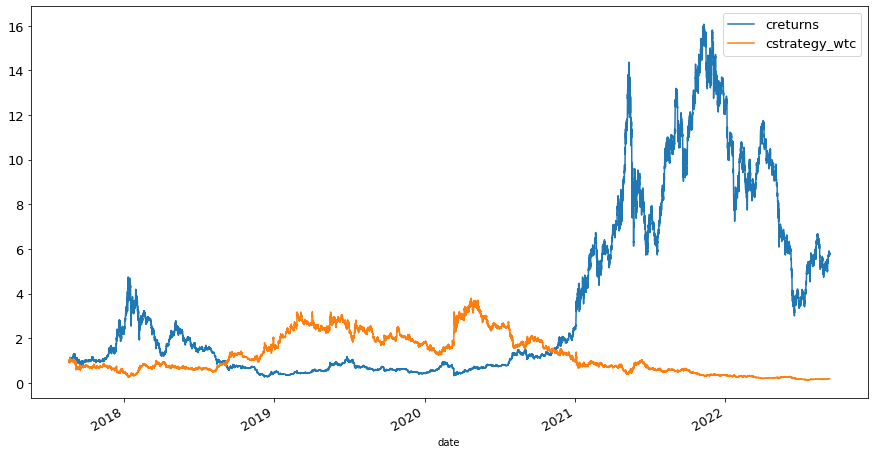

In [62]:
tester.plot_results()

In [44]:
tester.optimize_parameters((10,50,1), (20,60,1), (9,20,1))

array([21., 20.,  9.])

In [66]:
tester.update_and_run((21,20,9))

-0.5626874177354694

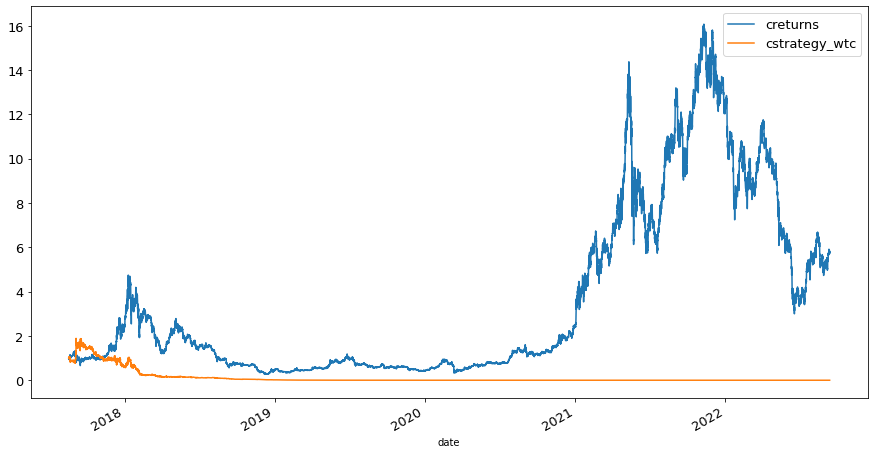

In [64]:
tester.plot_results()

In [67]:
tester.data

,open,high,low,close,volume,returns,creturns,EMA1,EMA2,MACD,MACD_signal,position,strategy,trades,strategy_wtc,cstrategy_wtc
date,,,,,,,,,,,,,,,,
2017-08-18 08:00:00,306.24,310.85,303.79,304.23,313.23742,-0.006585,1.008687,304.533608,304.501571,0.032037,0.048401,-1,NaN,0.0,NaN,NaN
2017-08-18 09:00:00,304.23,307.72,303.22,304.71,306.05941,0.001577,1.010278,304.550619,304.522459,0.028160,0.043866,-1,-0.001577,0.0,-0.001577,9.984247e-01
2017-08-18 10:00:00,304.73,311.06,304.73,308.88,332.56430,0.013592,1.024104,304.965831,304.956987,0.008844,0.036203,-1,-0.013592,0.0,-0.013592,9.849456e-01
2017-08-18 11:00:00,308.88,311.79,306.27,307.78,261.15170,-0.003568,1.020457,305.234384,305.237239,-0.002855,0.027815,-1,0.003568,0.0,0.003568,9.884658e-01
2017-08-18 12:00:00,307.78,310.29,305.73,308.47,388.17208,0.002239,1.022745,305.541766,305.556878,-0.015112,0.018730,-1,-0.002239,0.0,-0.002239,9.862547e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12 11:00:00,1744.93,1760.86,1740.62,1748.92,25514.51970,0.002290,5.798614,1748.415069,1748.298316,0.116753,0.095201,1,0.002290,0.0,0.002290,4.449366e-07
2022-09-12 12:00:00,1748.92,1750.08,1733.33,1746.63,24883.19360,-0.001310,5.791022,1748.252790,1748.139429,0.113361,0.098833,1,-0.001310,0.0,-0.001310,4.443540e-07
2022-09-12 13:00:00,1746.64,1753.74,1738.00,1751.51,24058.47290,0.002790,5.807201,1748.548900,1748.460436,0.088464,0.096759,-1,0.002790,2.0,0.000390,4.445273e-07
